# Credit Risk Assessment - Random Forest Model (SMOTE-Balanced)

This notebook trains a Random Forest model using **preprocessed data with SMOTE** from the data pipeline.

**What this notebook does:**
1. Load preprocessed data (with SMOTE already applied)
2. Train Random Forest model
3. Optimize classification threshold
4. Calibrate probabilities
5. Evaluate performance
6. Compare with XGBoost and Logistic Regression

**Data Pipeline Handles:**
- ✅ Data loading
- ✅ Train/val/test splits
- ✅ Preprocessing
- ✅ Feature engineering (12 risk indicators)
- ✅ SMOTE resampling (verified)
- ✅ Saved to `data/processed/`

## 1. Setup and Load Data

In [1]:
import sys
from pathlib import Path

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)

from src.data_pipeline import load_processed_data
from src.config import MODELS_DIR, RESULTS_DIR, FIGURES_DIR, RANDOM_FOREST_PARAMS
from src.evaluation import ModelEvaluator
from src.utils import setup_logging, set_seed
import pickle

# Setup
setup_logging()
set_seed(42)

print("✓ Imports successful!")

✓ Imports successful!


In [2]:
print("="*80)
print("LOADING PREPROCESSED DATA (WITH SMOTE)")
print("="*80)

# Load preprocessed data from data pipeline
X_train, y_train, X_val, y_val, X_test, y_test = load_processed_data()

print(f"\n✓ Data loaded successfully!")
print(f"\nDataset sizes:")
print(f"  Training: {len(X_train):,} samples, {X_train.shape[1]} features")
print(f"  Validation: {len(X_val):,} samples")
print(f"  Test: {len(X_test):,} samples")

print(f"\nTraining set class distribution (SMOTE-balanced):")
train_dist = y_train.value_counts().sort_index()
print(f"  Class 0 (good): {train_dist[0]:,} ({train_dist[0]/len(y_train)*100:.1f}%)")
print(f"  Class 1 (bad): {train_dist[1]:,} ({train_dist[1]/len(y_train)*100:.1f}%)")
print(f"  Imbalance ratio: {train_dist[0]/train_dist[1]:.2f}:1")

INFO:src.data_pipeline:Loading processed data...


LOADING PREPROCESSED DATA (WITH SMOTE)


INFO:src.data_pipeline:✓ Training data (SMOTE-balanced): (364313, 103)
INFO:src.data_pipeline:✓ Validation data: (75000, 103)
INFO:src.data_pipeline:✓ Test data: (100000, 103)



✓ Data loaded successfully!

Dataset sizes:
  Training: 364,313 samples, 103 features
  Validation: 75,000 samples
  Test: 100,000 samples

Training set class distribution (SMOTE-balanced):
  Class 0 (good): 260,224 (71.4%)
  Class 1 (bad): 104,089 (28.6%)
  Imbalance ratio: 2.50:1


## 2. Train Random Forest Model

In [3]:
print("="*80)
print("TRAINING RANDOM FOREST ON SMOTE-BALANCED DATA")
print("="*80)

# Prepare parameters from config
params = RANDOM_FOREST_PARAMS.copy()

# Adjust class weight for SMOTE-balanced data
class_weight_ratio = train_dist[0] / train_dist[1]
params['class_weight'] = {0: 1.0, 1: class_weight_ratio}

print(f"\nModel configuration:")
print(f"  n_estimators: {params['n_estimators']}")
print(f"  max_depth: {params['max_depth']}")
print(f"  min_samples_split: {params['min_samples_split']}")
print(f"  min_samples_leaf: {params['min_samples_leaf']}")
print(f"  max_features: {params['max_features']}")
print(f"  class_weight: {params['class_weight']}")
print(f"  n_jobs: {params['n_jobs']} (parallel processing)")

print(f"\nTraining model (this may take a few minutes)...")

# Train Random Forest
rf_model = RandomForestClassifier(**params)
rf_model.fit(X_train, y_train)

print(f"\n✓ Training complete!")
print(f"  Trees trained: {rf_model.n_estimators}")
print(f"  Features used per tree: {rf_model.max_features}")

# Save model
model_path = MODELS_DIR / 'random_forest_smote.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(rf_model, f)
print(f"\n✓ Model saved to {model_path}")

TRAINING RANDOM FOREST ON SMOTE-BALANCED DATA

Model configuration:
  n_estimators: 200
  max_depth: 15
  min_samples_split: 10
  min_samples_leaf: 5
  max_features: sqrt
  class_weight: {0: 1.0, 1: np.float64(2.5000144107446514)}
  n_jobs: -1 (parallel processing)

Training model (this may take a few minutes)...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.7min finished



✓ Training complete!
  Trees trained: 200
  Features used per tree: sqrt

✓ Model saved to c:\Users\Faheem\Desktop\Umair FYP\FYP2025\credit_risk_fyp\models\random_forest_smote.pkl


## 3. Make Predictions

In [4]:
print("Making predictions...")

# Get probability predictions
y_val_proba = rf_model.predict_proba(X_val)[:, 1]
y_test_proba = rf_model.predict_proba(X_test)[:, 1]

print(f"\n✓ Validation predictions: {len(y_val_proba):,}")
print(f"✓ Test predictions: {len(y_test_proba):,}")

Making predictions...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s



✓ Validation predictions: 75,000
✓ Test predictions: 100,000


[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    1.6s finished


## 4. Optimize Classification Threshold

In [5]:
print("="*80)
print("OPTIMIZING CLASSIFICATION THRESHOLD")
print("="*80)

evaluator = ModelEvaluator()

# Find optimal thresholds for different metrics
print("\nFinding optimal thresholds on validation set:\n")

optimal_thresholds = {}
for metric in ['f1', 'precision', 'recall']:
    threshold, score = evaluator.optimize_threshold(
        y_val, y_val_proba, metric=metric
    )
    optimal_thresholds[metric] = threshold
    print(f"{metric.upper():<15} Optimal threshold: {threshold:.4f}, Score: {score:.4f}")

# Use F1-optimized threshold as default
optimal_threshold = optimal_thresholds['f1']
print(f"\n✓ Using F1-optimized threshold: {optimal_threshold:.4f}")

OPTIMIZING CLASSIFICATION THRESHOLD

Finding optimal thresholds on validation set:



2025-12-10 04:03:35,452 - credit_risk_fyp.evaluation - INFO - Optimal threshold for f1: 0.4141 (score: 0.4295)
INFO:credit_risk_fyp.evaluation:Optimal threshold for f1: 0.4141 (score: 0.4295)


F1              Optimal threshold: 0.4141, Score: 0.4295


2025-12-10 04:03:37,216 - credit_risk_fyp.evaluation - INFO - Optimal threshold for precision: 0.8081 (score: 1.0000)
INFO:credit_risk_fyp.evaluation:Optimal threshold for precision: 0.8081 (score: 1.0000)


PRECISION       Optimal threshold: 0.8081, Score: 1.0000


2025-12-10 04:03:39,143 - credit_risk_fyp.evaluation - INFO - Optimal threshold for recall: 0.0000 (score: 1.0000)
INFO:credit_risk_fyp.evaluation:Optimal threshold for recall: 0.0000 (score: 1.0000)


RECALL          Optimal threshold: 0.0000, Score: 1.0000

✓ Using F1-optimized threshold: 0.4141


## 5. Probability Calibration

In [6]:
print("="*80)
print("PROBABILITY CALIBRATION (ISOTONIC REGRESSION)")
print("="*80)

# Calibrate validation set probabilities
y_val_calibrated, cal_metrics_val = evaluator.calibrate_probabilities(
    y_val, y_val_proba, method='isotonic'
)

print(f"\nValidation Set Calibration Results:")
print(f"  Method: {cal_metrics_val['method']}")
print(f"  Brier Score: {cal_metrics_val['brier_score_before']:.4f} → {cal_metrics_val['brier_score_after']:.4f} "
      f"(improvement: {cal_metrics_val['brier_improvement']:+.4f})")
print(f"  Log Loss: {cal_metrics_val['log_loss_before']:.4f} → {cal_metrics_val['log_loss_after']:.4f} "
      f"(improvement: {cal_metrics_val['log_loss_improvement']:+.4f})")
print(f"  Expected Calibration Error: {cal_metrics_val['ece_before']:.4f} → {cal_metrics_val['ece_after']:.4f} "
      f"(improvement: {cal_metrics_val['ece_improvement']:+.4f})")

# Calibrate test set probabilities
y_test_calibrated, cal_metrics_test = evaluator.calibrate_probabilities(
    y_test, y_test_proba, method='isotonic'
)

print(f"\nTest Set Calibration Results:")
print(f"  Method: {cal_metrics_test['method']}")
print(f"  Brier Score: {cal_metrics_test['brier_score_before']:.4f} → {cal_metrics_test['brier_score_after']:.4f} "
      f"(improvement: {cal_metrics_test['brier_improvement']:+.4f})")
print(f"  Log Loss: {cal_metrics_test['log_loss_before']:.4f} → {cal_metrics_test['log_loss_after']:.4f} "
      f"(improvement: {cal_metrics_test['log_loss_improvement']:+.4f})")
print(f"  Expected Calibration Error: {cal_metrics_test['ece_before']:.4f} → {cal_metrics_test['ece_after']:.4f} "
      f"(improvement: {cal_metrics_test['ece_improvement']:+.4f})")

print(f"\n✓ Probability calibration complete!")

2025-12-10 04:03:39,182 - credit_risk_fyp.evaluation - INFO - Calibrating probabilities using isotonic method...
INFO:credit_risk_fyp.evaluation:Calibrating probabilities using isotonic method...
2025-12-10 04:03:39,308 - credit_risk_fyp.evaluation - INFO - Calibration complete:
INFO:credit_risk_fyp.evaluation:Calibration complete:
2025-12-10 04:03:39,312 - credit_risk_fyp.evaluation - INFO -   Brier score: 0.1692 → 0.1437 (improvement: 0.0254)
INFO:credit_risk_fyp.evaluation:  Brier score: 0.1692 → 0.1437 (improvement: 0.0254)
2025-12-10 04:03:39,316 - credit_risk_fyp.evaluation - INFO -   Log loss: 0.5164 → 0.4511 (improvement: 0.0653)
INFO:credit_risk_fyp.evaluation:  Log loss: 0.5164 → 0.4511 (improvement: 0.0653)
2025-12-10 04:03:39,319 - credit_risk_fyp.evaluation - INFO -   ECE: 0.1351 → 0.0000 (improvement: 0.1351)
INFO:credit_risk_fyp.evaluation:  ECE: 0.1351 → 0.0000 (improvement: 0.1351)
2025-12-10 04:03:39,324 - credit_risk_fyp.evaluation - INFO - Calibrating probabilities 

PROBABILITY CALIBRATION (ISOTONIC REGRESSION)

Validation Set Calibration Results:
  Method: isotonic
  Brier Score: 0.1692 → 0.1437 (improvement: +0.0254)
  Log Loss: 0.5164 → 0.4511 (improvement: +0.0653)
  Expected Calibration Error: 0.1351 → 0.0000 (improvement: +0.1351)


2025-12-10 04:03:39,459 - credit_risk_fyp.evaluation - INFO - Calibration complete:
INFO:credit_risk_fyp.evaluation:Calibration complete:
2025-12-10 04:03:39,463 - credit_risk_fyp.evaluation - INFO -   Brier score: 0.1698 → 0.1444 (improvement: 0.0254)
INFO:credit_risk_fyp.evaluation:  Brier score: 0.1698 → 0.1444 (improvement: 0.0254)
2025-12-10 04:03:39,467 - credit_risk_fyp.evaluation - INFO -   Log loss: 0.5179 → 0.4527 (improvement: 0.0652)
INFO:credit_risk_fyp.evaluation:  Log loss: 0.5179 → 0.4527 (improvement: 0.0652)
2025-12-10 04:03:39,471 - credit_risk_fyp.evaluation - INFO -   ECE: 0.1365 → 0.0000 (improvement: 0.1365)
INFO:credit_risk_fyp.evaluation:  ECE: 0.1365 → 0.0000 (improvement: 0.1365)



Test Set Calibration Results:
  Method: isotonic
  Brier Score: 0.1698 → 0.1444 (improvement: +0.0254)
  Log Loss: 0.5179 → 0.4527 (improvement: +0.0652)
  Expected Calibration Error: 0.1365 → 0.0000 (improvement: +0.1365)

✓ Probability calibration complete!



Generating calibration plots...


2025-12-10 04:03:41,396 - credit_risk_fyp.evaluation - INFO - Calibration curve saved to c:\Users\Faheem\Desktop\Umair FYP\FYP2025\credit_risk_fyp\results\figures\calibration_curve_randomforest_smote_validation.png
INFO:credit_risk_fyp.evaluation:Calibration curve saved to c:\Users\Faheem\Desktop\Umair FYP\FYP2025\credit_risk_fyp\results\figures\calibration_curve_randomforest_smote_validation.png
2025-12-10 04:03:42,693 - credit_risk_fyp.evaluation - INFO - Calibration curve saved to c:\Users\Faheem\Desktop\Umair FYP\FYP2025\credit_risk_fyp\results\figures\calibration_curve_randomforest_smote_test.png
INFO:credit_risk_fyp.evaluation:Calibration curve saved to c:\Users\Faheem\Desktop\Umair FYP\FYP2025\credit_risk_fyp\results\figures\calibration_curve_randomforest_smote_test.png


✓ Calibration curves saved


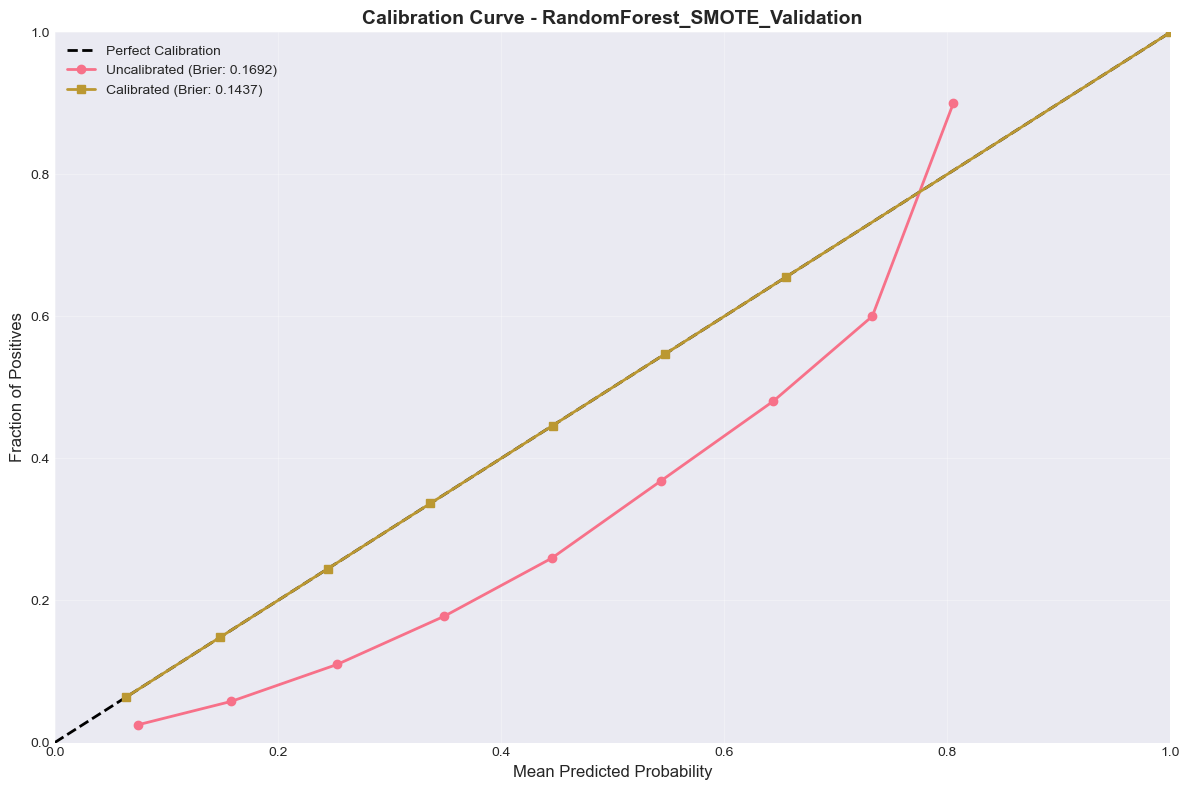

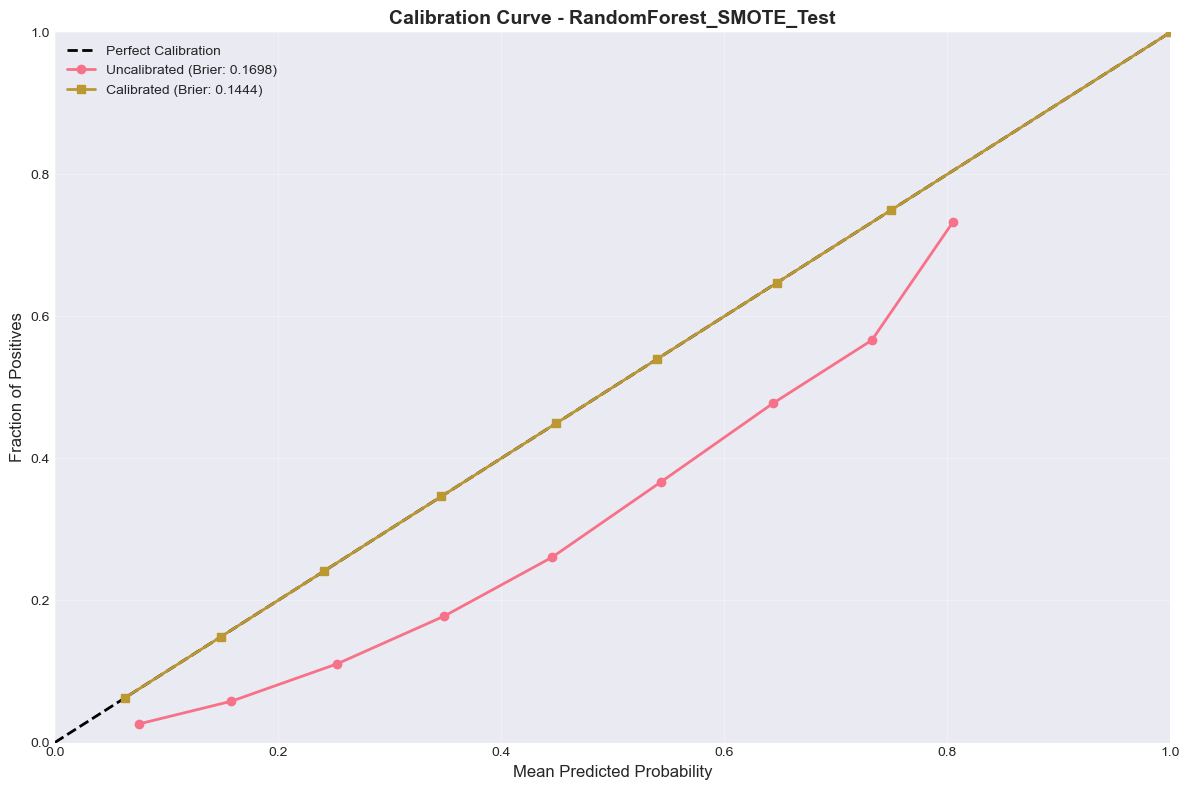

In [7]:
# Plot calibration curves
print("\nGenerating calibration plots...")

# Validation set calibration curve
evaluator.plot_calibration_curve(
    y_val, y_val_proba, y_val_calibrated,
    model_name="RandomForest_SMOTE_Validation",
    n_bins=10,
    save=True
)

# Test set calibration curve
evaluator.plot_calibration_curve(
    y_test, y_test_proba, y_test_calibrated,
    model_name="RandomForest_SMOTE_Test",
    n_bins=10,
    save=True
)

print("✓ Calibration curves saved")

## 6. Evaluate Model (Validation Set)

In [8]:
print("="*80)
print("VALIDATION SET RESULTS")
print("="*80)

val_metrics = evaluator.evaluate(
    y_val, y_val_proba,
    threshold=optimal_threshold,
    model_name="RandomForest_SMOTE_Validation"
)

print("\nKey Metrics:")
print(f"  AUC-ROC: {val_metrics['roc_auc']:.4f}")
print(f"  Accuracy: {val_metrics['accuracy']:.4f}")
print(f"  Precision: {val_metrics['precision']:.4f}")
print(f"  Recall: {val_metrics['recall']:.4f}")
print(f"  F1-Score: {val_metrics['f1_score']:.4f}")
print(f"  PR-AUC: {val_metrics['pr_auc']:.4f}")
print(f"  MCC: {val_metrics['matthews_corr_coef']:.4f}")
print(f"  Cohen's Kappa: {val_metrics['cohen_kappa']:.4f}")

2025-12-10 04:03:43,458 - credit_risk_fyp.evaluation - INFO - Evaluating RandomForest_SMOTE_Validation...
INFO:credit_risk_fyp.evaluation:Evaluating RandomForest_SMOTE_Validation...


VALIDATION SET RESULTS


2025-12-10 04:03:43,708 - credit_risk_fyp.evaluation - INFO - RandomForest_SMOTE_Validation Results:
INFO:credit_risk_fyp.evaluation:RandomForest_SMOTE_Validation Results:
2025-12-10 04:03:43,709 - credit_risk_fyp.evaluation - INFO -   AUC-ROC: 0.7122
INFO:credit_risk_fyp.evaluation:  AUC-ROC: 0.7122
2025-12-10 04:03:43,714 - credit_risk_fyp.evaluation - INFO -   Accuracy: 0.7019
INFO:credit_risk_fyp.evaluation:  Accuracy: 0.7019
2025-12-10 04:03:43,718 - credit_risk_fyp.evaluation - INFO -   Precision: 0.3471
INFO:credit_risk_fyp.evaluation:  Precision: 0.3471
2025-12-10 04:03:43,720 - credit_risk_fyp.evaluation - INFO -   Recall: 0.5631
INFO:credit_risk_fyp.evaluation:  Recall: 0.5631
2025-12-10 04:03:43,723 - credit_risk_fyp.evaluation - INFO -   F1-Score: 0.4295
INFO:credit_risk_fyp.evaluation:  F1-Score: 0.4295



Key Metrics:
  AUC-ROC: 0.7122
  Accuracy: 0.7019
  Precision: 0.3471
  Recall: 0.5631
  F1-Score: 0.4295
  PR-AUC: 0.3852
  MCC: 0.2558
  Cohen's Kappa: 0.2428


## 7. Evaluate Model (Test Set)

In [9]:
print("="*80)
print("TEST SET RESULTS")
print("="*80)

test_metrics = evaluator.evaluate(
    y_test, y_test_proba,
    threshold=optimal_threshold,
    model_name="RandomForest_SMOTE_Test"
)

print("\nKey Metrics:")
print(f"  AUC-ROC: {test_metrics['roc_auc']:.4f}")
print(f"  Accuracy: {test_metrics['accuracy']:.4f}")
print(f"  Precision: {test_metrics['precision']:.4f}")
print(f"  Recall: {test_metrics['recall']:.4f}")
print(f"  F1-Score: {test_metrics['f1_score']:.4f}")
print(f"  PR-AUC: {test_metrics['pr_auc']:.4f}")
print(f"  MCC: {test_metrics['matthews_corr_coef']:.4f}")
print(f"  Cohen's Kappa: {test_metrics['cohen_kappa']:.4f}")

2025-12-10 04:03:43,747 - credit_risk_fyp.evaluation - INFO - Evaluating RandomForest_SMOTE_Test...
INFO:credit_risk_fyp.evaluation:Evaluating RandomForest_SMOTE_Test...


TEST SET RESULTS


2025-12-10 04:03:43,942 - credit_risk_fyp.evaluation - INFO - RandomForest_SMOTE_Test Results:
INFO:credit_risk_fyp.evaluation:RandomForest_SMOTE_Test Results:
2025-12-10 04:03:43,948 - credit_risk_fyp.evaluation - INFO -   AUC-ROC: 0.7106
INFO:credit_risk_fyp.evaluation:  AUC-ROC: 0.7106
2025-12-10 04:03:43,951 - credit_risk_fyp.evaluation - INFO -   Accuracy: 0.7000
INFO:credit_risk_fyp.evaluation:  Accuracy: 0.7000
2025-12-10 04:03:43,954 - credit_risk_fyp.evaluation - INFO -   Precision: 0.3445
INFO:credit_risk_fyp.evaluation:  Precision: 0.3445
2025-12-10 04:03:43,957 - credit_risk_fyp.evaluation - INFO -   Recall: 0.5592
INFO:credit_risk_fyp.evaluation:  Recall: 0.5592
2025-12-10 04:03:43,961 - credit_risk_fyp.evaluation - INFO -   F1-Score: 0.4263
INFO:credit_risk_fyp.evaluation:  F1-Score: 0.4263



Key Metrics:
  AUC-ROC: 0.7106
  Accuracy: 0.7000
  Precision: 0.3445
  Recall: 0.5592
  F1-Score: 0.4263
  PR-AUC: 0.3774
  MCC: 0.2513
  Cohen's Kappa: 0.2385


## 8. Generate Visualizations

2025-12-10 04:03:43,993 - credit_risk_fyp.evaluation - INFO - Generating all evaluation plots for RandomForest_SMOTE_Validation...
INFO:credit_risk_fyp.evaluation:Generating all evaluation plots for RandomForest_SMOTE_Validation...


Generating evaluation plots...


2025-12-10 04:03:45,412 - credit_risk_fyp.evaluation - INFO - ROC curve saved to c:\Users\Faheem\Desktop\Umair FYP\FYP2025\credit_risk_fyp\results\figures\roc_curve_randomforest_smote_validation.png
INFO:credit_risk_fyp.evaluation:ROC curve saved to c:\Users\Faheem\Desktop\Umair FYP\FYP2025\credit_risk_fyp\results\figures\roc_curve_randomforest_smote_validation.png
2025-12-10 04:03:46,724 - credit_risk_fyp.evaluation - INFO - PR curve saved to c:\Users\Faheem\Desktop\Umair FYP\FYP2025\credit_risk_fyp\results\figures\pr_curve_randomforest_smote_validation.png
INFO:credit_risk_fyp.evaluation:PR curve saved to c:\Users\Faheem\Desktop\Umair FYP\FYP2025\credit_risk_fyp\results\figures\pr_curve_randomforest_smote_validation.png
2025-12-10 04:03:47,380 - credit_risk_fyp.evaluation - INFO - Confusion matrix saved to c:\Users\Faheem\Desktop\Umair FYP\FYP2025\credit_risk_fyp\results\figures\confusion_matrix_randomforest_smote_validation.png
INFO:credit_risk_fyp.evaluation:Confusion matrix saved 

✓ All plots saved to results/figures/


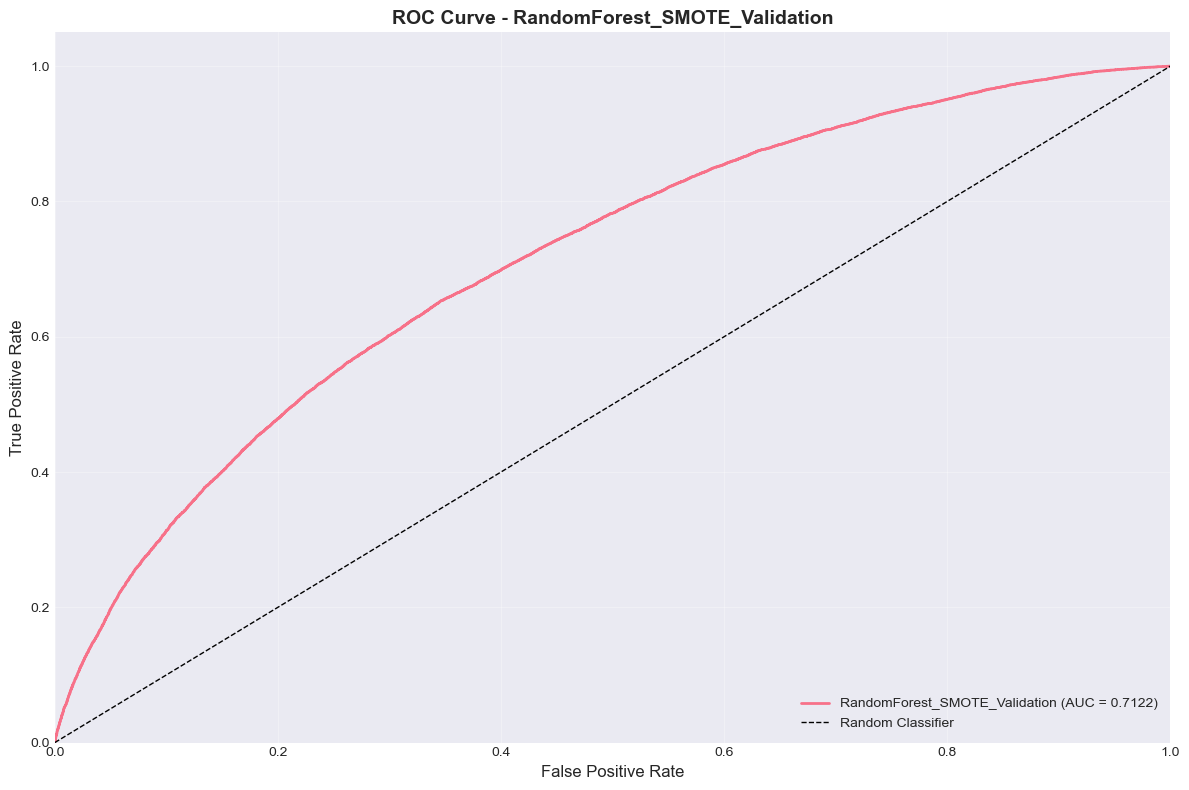

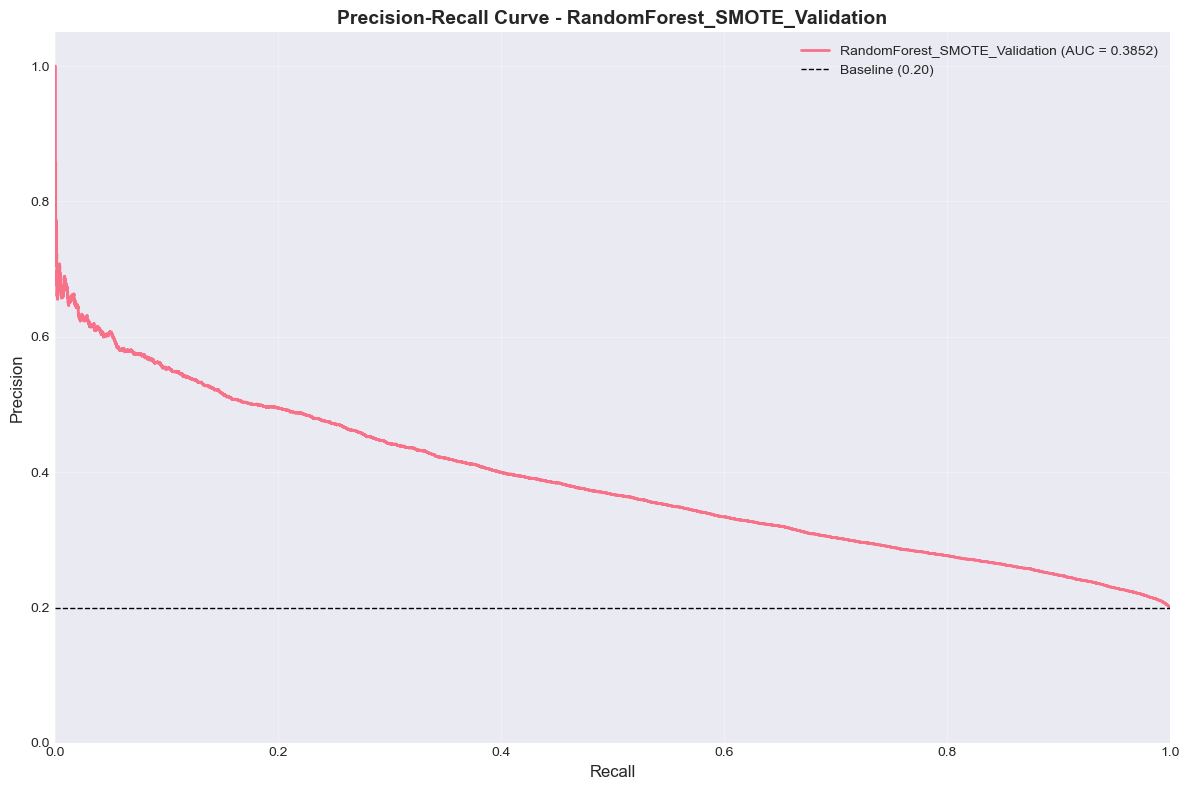

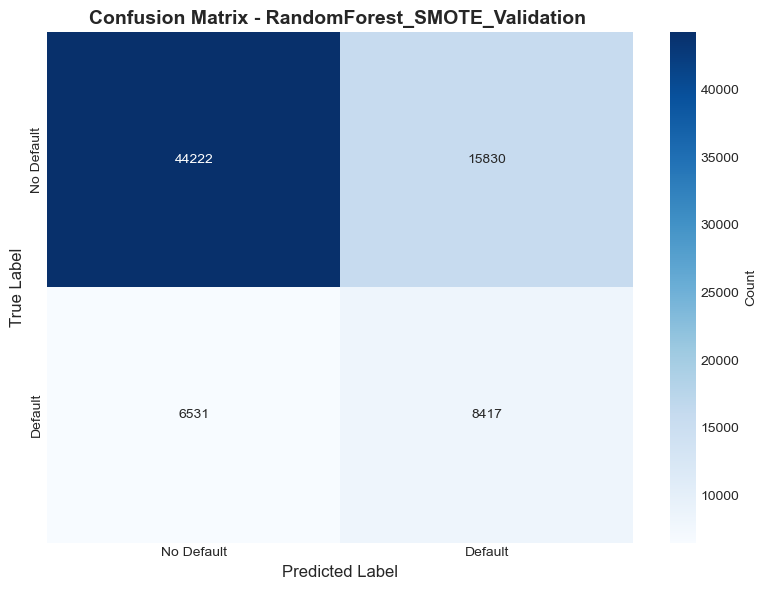

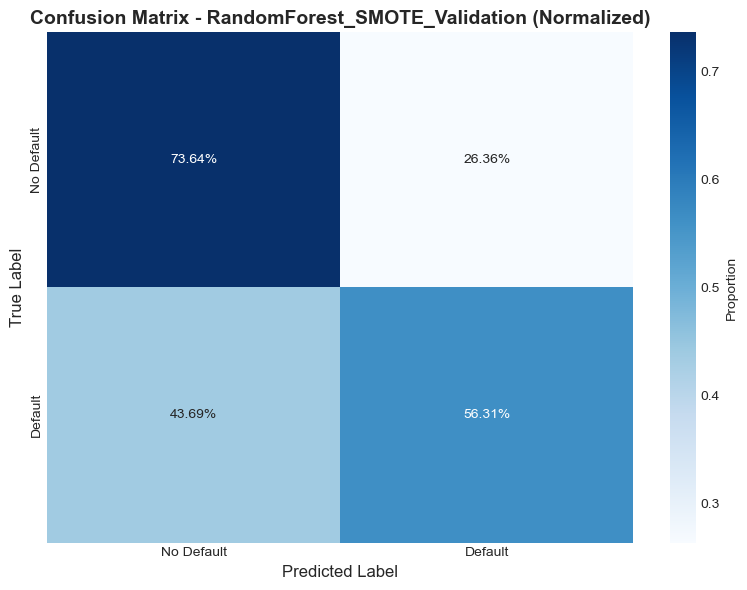

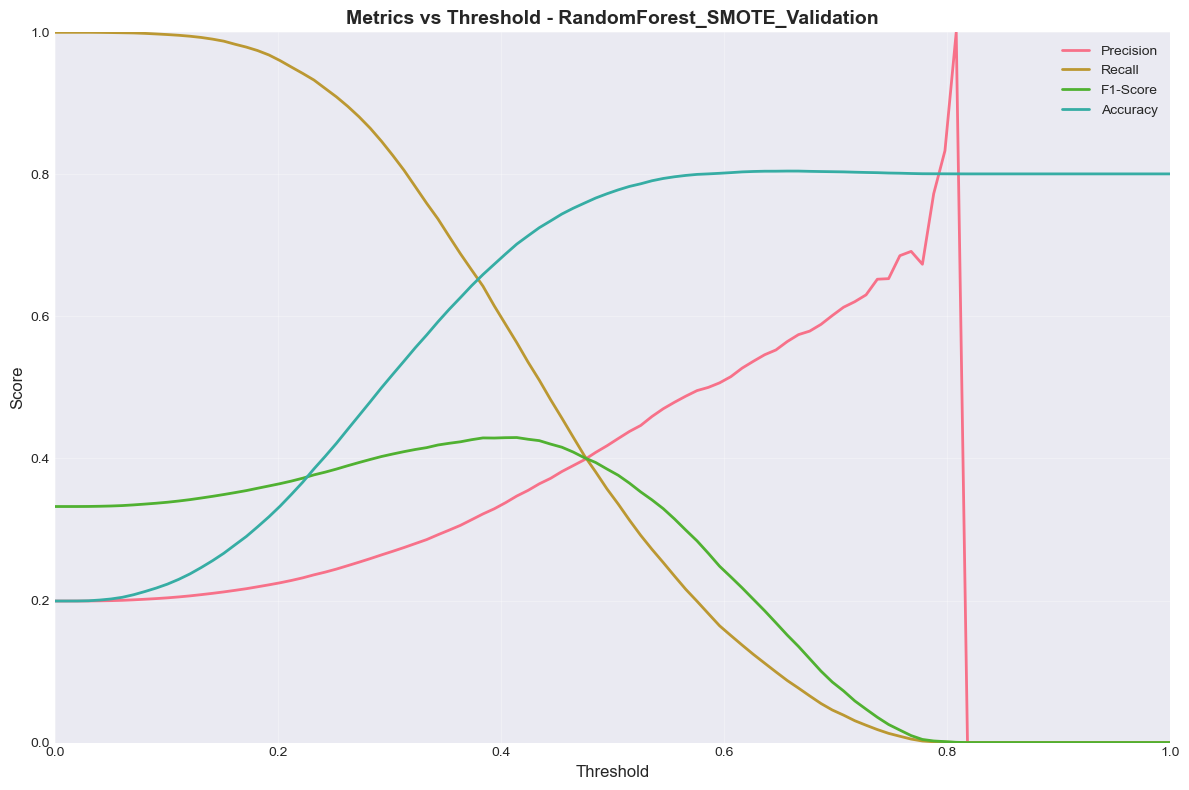

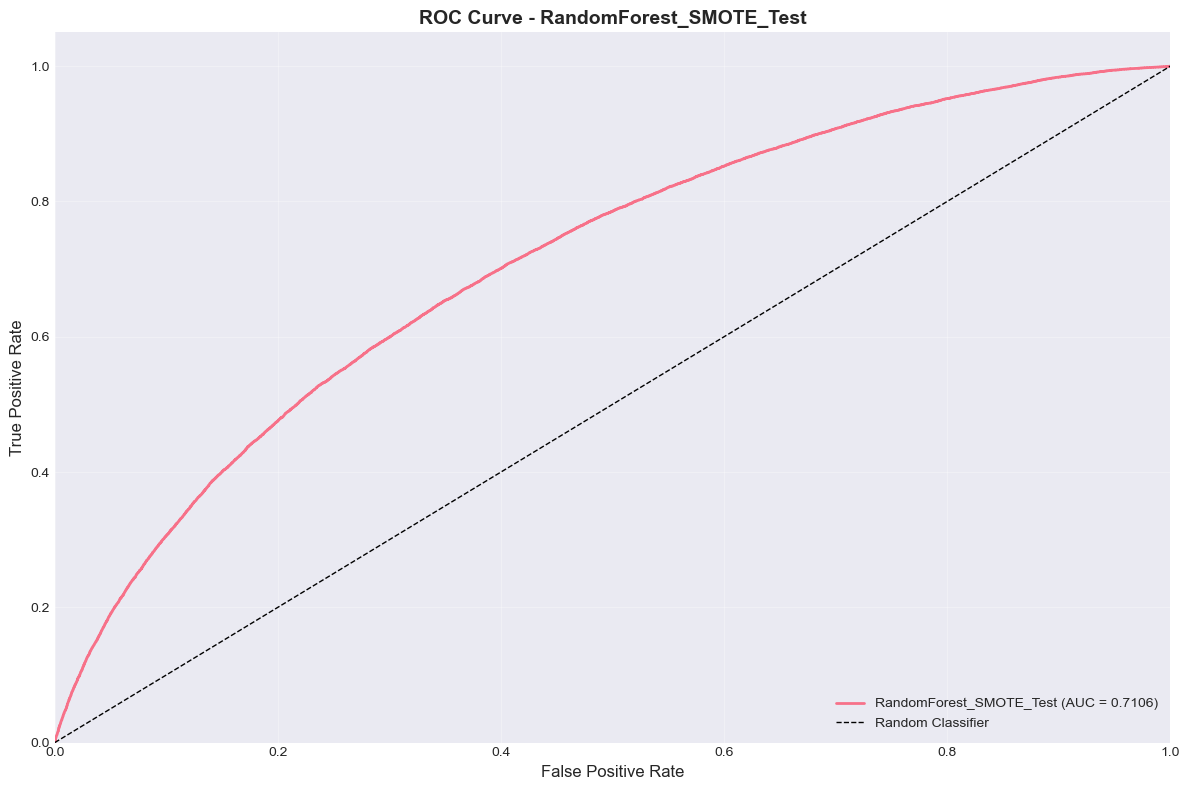

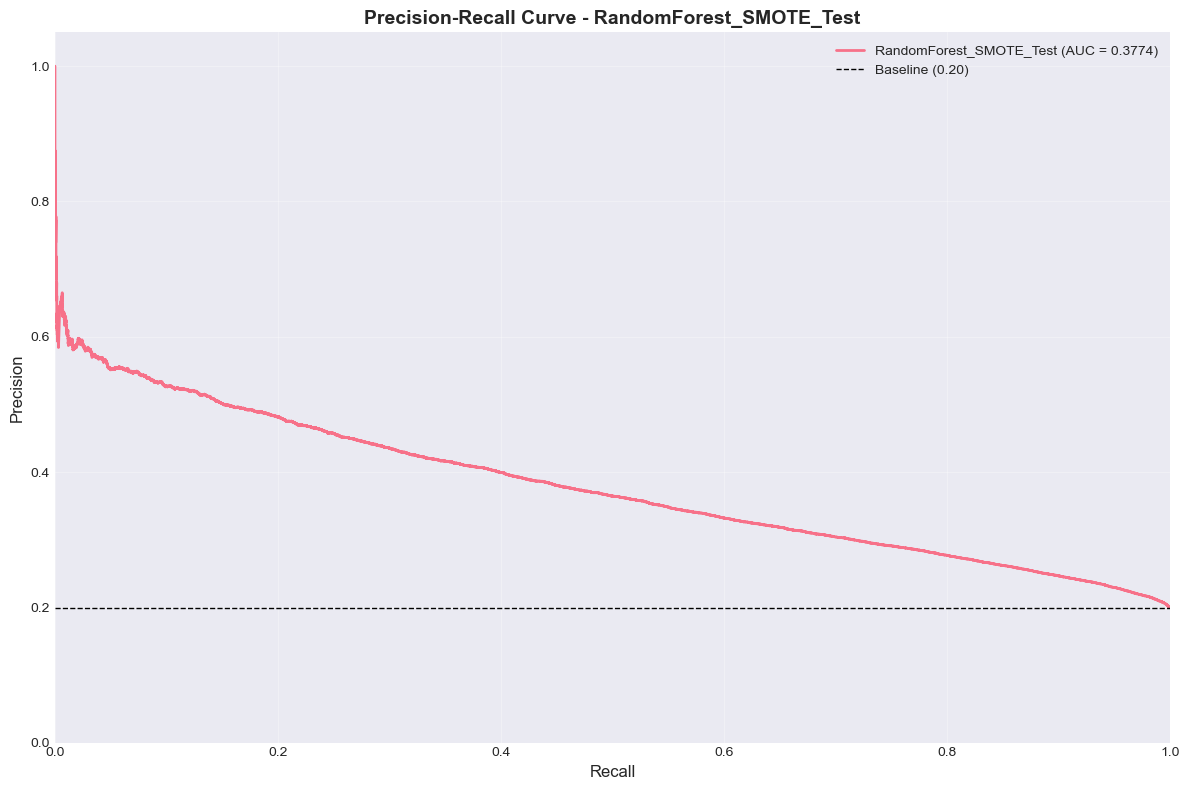

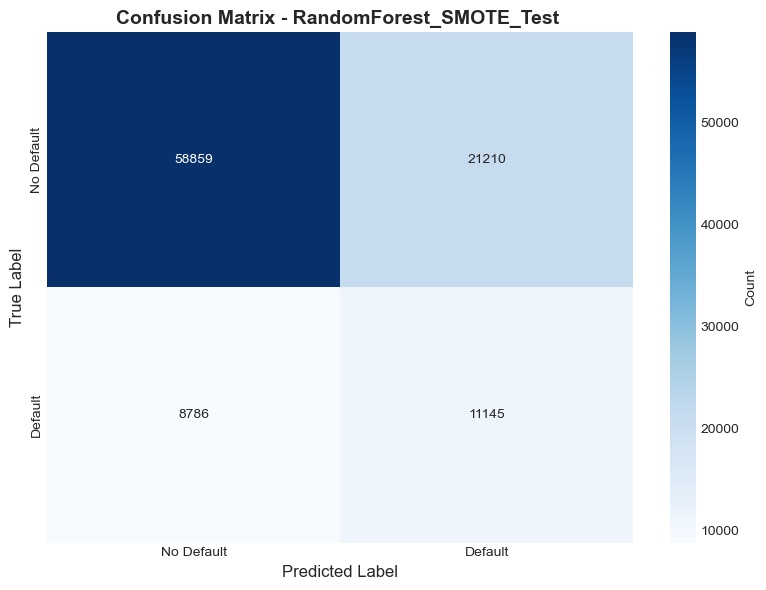

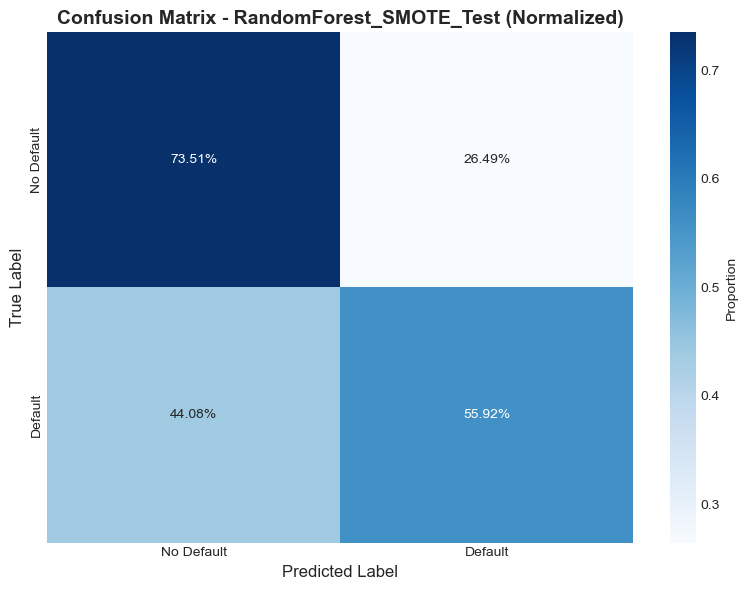

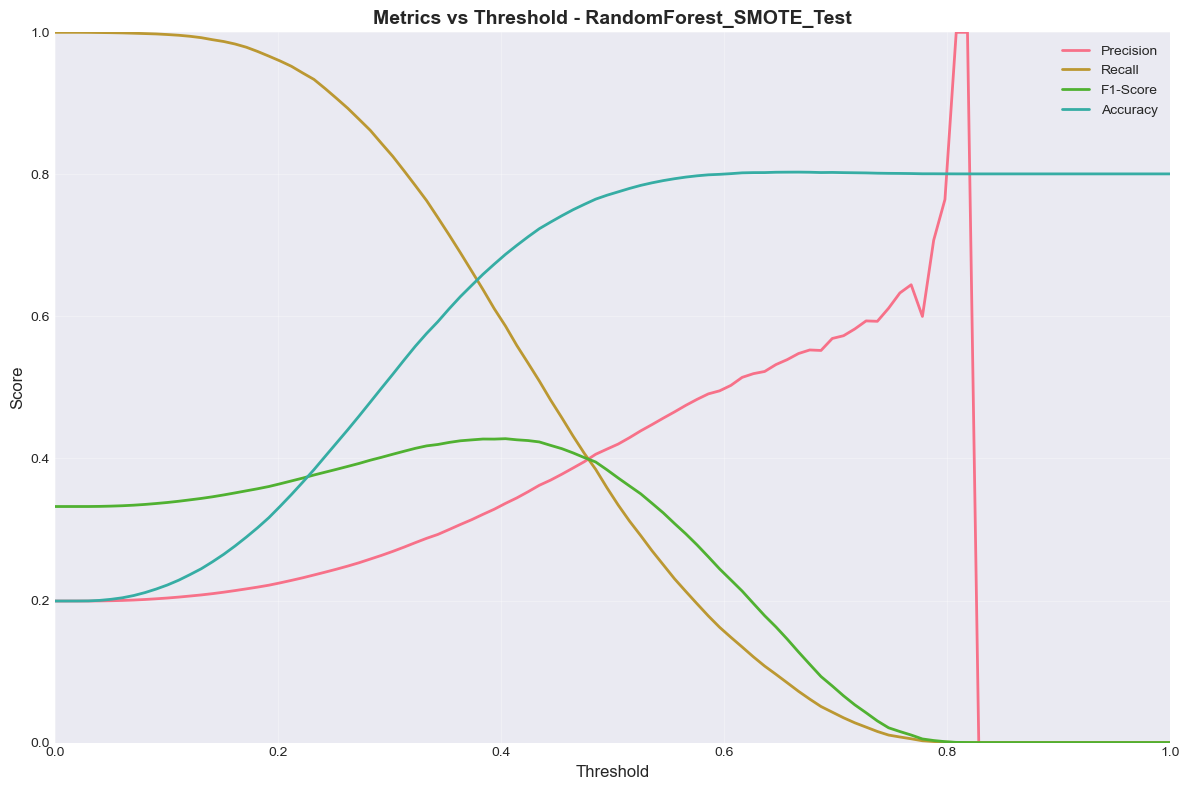

In [10]:
print("Generating evaluation plots...")

val_figures = evaluator.evaluate_all_plots(
    y_val, y_val_proba,
    model_name="RandomForest_SMOTE_Validation",
    threshold=optimal_threshold,
    save=True
)

test_figures = evaluator.evaluate_all_plots(
    y_test, y_test_proba,
    model_name="RandomForest_SMOTE_Test",
    threshold=optimal_threshold,
    save=True
)

print("✓ All plots saved to results/figures/")

## 9. Feature Importance Analysis

FEATURE IMPORTANCE (RANDOM FOREST)

Top 20 Most Important Features:

             Feature  Importance
                term    0.143022
      home_ownership    0.045430
 high_loan_to_income    0.044048
      inq_last_6mths    0.042045
 recent_inquiry_rate    0.041477
    loan_amnt_bucket    0.031788
     fico_range_high    0.030727
      fico_range_low    0.026572
acc_open_past_24mths    0.025453
       income_bucket    0.024841
  num_tl_op_past_12m    0.022937
           loan_amnt    0.017416
        inquiry_risk    0.015379
           dti_ratio    0.015088
 initial_list_status    0.015025
       fico_dti_risk    0.014922
                 dti    0.014462
      loan_to_income    0.013942
loan_to_income_ratio    0.013917
          fico_x_dti    0.013323


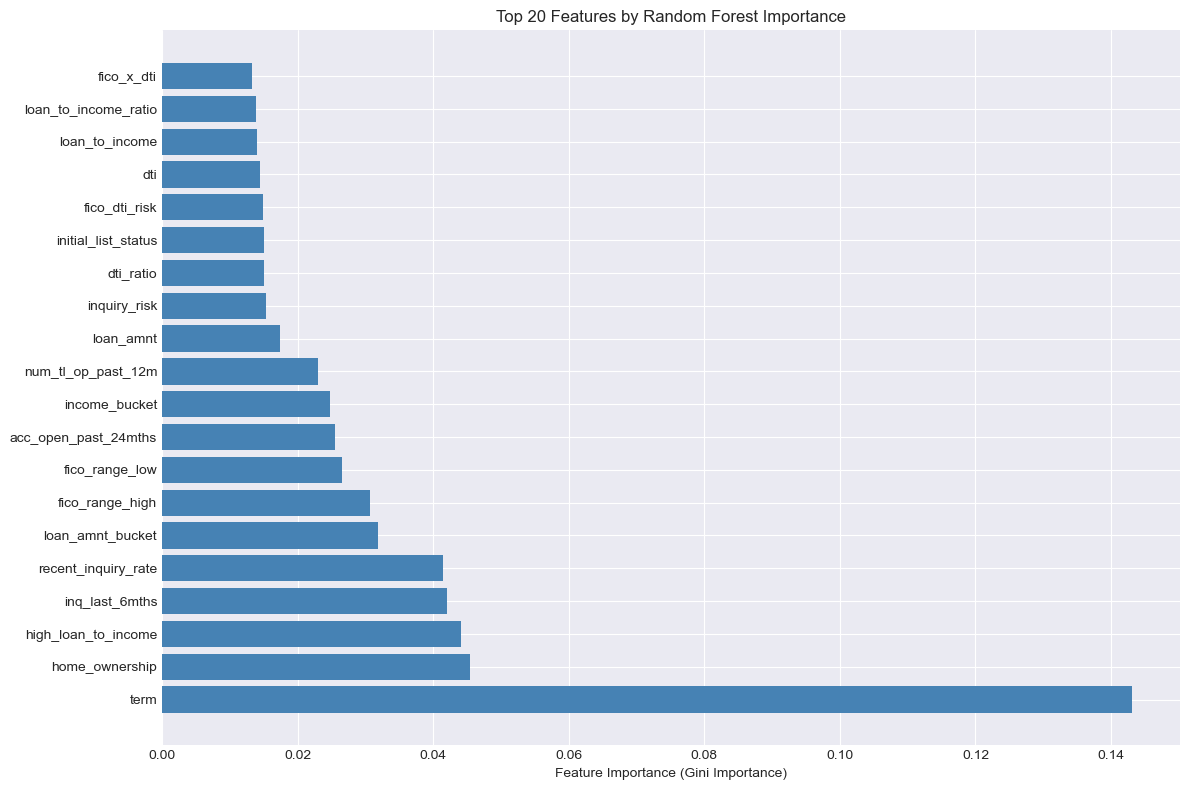


✓ Feature importance plot saved


In [11]:
print("="*80)
print("FEATURE IMPORTANCE (RANDOM FOREST)")
print("="*80)

# Get feature importance
feature_names = X_train.columns
importances = rf_model.feature_importances_

# Create importance dataframe
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

print("\nTop 20 Most Important Features:\n")
print(importance_df.head(20).to_string(index=False))

# Plot feature importance
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
top_features = importance_df.head(20)
plt.barh(range(len(top_features)), top_features['Importance'], color='steelblue')
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Feature Importance (Gini Importance)')
plt.title('Top 20 Features by Random Forest Importance')
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'random_forest_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Feature importance plot saved")

## 10. Model Training Summary

In [12]:
print("="*80)
print("MODEL TRAINING SUMMARY - RANDOM FOREST")
print("="*80)

print(f"\n📊 DATASET INFORMATION:")
print(f"  Training samples: {len(X_train):,} (SMOTE-balanced)")
print(f"  Validation samples: {len(X_val):,}")
print(f"  Test samples: {len(X_test):,}")
print(f"  Features: {X_train.shape[1]}")
print(f"  SMOTE ratio: {train_dist[0]/train_dist[1]:.2f}:1")

print(f"\n🎯 TEST SET PERFORMANCE:")
print(f"  AUC-ROC: {test_metrics['roc_auc']:.4f}")
print(f"  Precision: {test_metrics['precision']:.4f}")
print(f"  Recall: {test_metrics['recall']:.4f}")
print(f"  F1-Score: {test_metrics['f1_score']:.4f}")
print(f"  Optimal Threshold: {optimal_threshold:.4f}")

print(f"\n💾 SAVED ARTIFACTS:")
print(f"  Model: {model_path}")
print(f"  Figures: results/figures/")

print(f"\n✅ TRAINING COMPLETE!")
print("="*80)

MODEL TRAINING SUMMARY - RANDOM FOREST

📊 DATASET INFORMATION:
  Training samples: 364,313 (SMOTE-balanced)
  Validation samples: 75,000
  Test samples: 100,000
  Features: 103
  SMOTE ratio: 2.50:1

🎯 TEST SET PERFORMANCE:
  AUC-ROC: 0.7106
  Precision: 0.3445
  Recall: 0.5592
  F1-Score: 0.4263
  Optimal Threshold: 0.4141

💾 SAVED ARTIFACTS:
  Model: c:\Users\Faheem\Desktop\Umair FYP\FYP2025\credit_risk_fyp\models\random_forest_smote.pkl
  Figures: results/figures/

✅ TRAINING COMPLETE!


## 11. Detailed Classification Metrics (TPR/FPR)

In [13]:
print("="*80)
print("DETAILED CLASSIFICATION METRICS")
print("="*80)

print(f"\n📊 CONFUSION MATRIX BREAKDOWN:")
print(f"  True Positives (TP):  {test_metrics['true_positives']:,}")
print(f"  True Negatives (TN):  {test_metrics['true_negatives']:,}")
print(f"  False Positives (FP): {test_metrics['false_positives']:,}")
print(f"  False Negatives (FN): {test_metrics['false_negatives']:,}")

print(f"\n🎯 RATES & SPECIFICITY:")
print(f"  TPR (True Positive Rate / Recall):      {test_metrics['recall']:.4f} ({test_metrics['recall']*100:.2f}%)")
print(f"  FPR (False Positive Rate):              {test_metrics['false_positive_rate']:.4f} ({test_metrics['false_positive_rate']*100:.2f}%)")
print(f"  TNR (True Negative Rate / Specificity): {test_metrics['specificity']:.4f} ({test_metrics['specificity']*100:.2f}%)")
print(f"  FNR (False Negative Rate):              {test_metrics['false_negative_rate']:.4f} ({test_metrics['false_negative_rate']*100:.2f}%)")

print(f"\n💡 INTERPRETATION:")
print(f"  • Out of 100 actual defaulters, we correctly identify {test_metrics['recall']*100:.1f}")
print(f"  • Out of 100 good loans, we incorrectly flag {test_metrics['false_positive_rate']*100:.1f} as risky")
print(f"  • Out of 100 good loans, we correctly identify {test_metrics['specificity']*100:.1f} as good")

print("\n" + "="*80)

DETAILED CLASSIFICATION METRICS

📊 CONFUSION MATRIX BREAKDOWN:
  True Positives (TP):  11,145
  True Negatives (TN):  58,859
  False Positives (FP): 21,210
  False Negatives (FN): 8,786

🎯 RATES & SPECIFICITY:
  TPR (True Positive Rate / Recall):      0.5592 (55.92%)
  FPR (False Positive Rate):              0.2649 (26.49%)
  TNR (True Negative Rate / Specificity): 0.7351 (73.51%)
  FNR (False Negative Rate):              0.4408 (44.08%)

💡 INTERPRETATION:
  • Out of 100 actual defaulters, we correctly identify 55.9
  • Out of 100 good loans, we incorrectly flag 26.5 as risky
  • Out of 100 good loans, we correctly identify 73.5 as good



## 12. MODEL COMPARISON TABLE

In [14]:
print("="*80)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*80)

# Create comparison dataframe
comparison_data = {
    'Model': ['Baseline', 'XGBoost (SMOTE)', 'Logistic Regression (SMOTE)', 'Random Forest (SMOTE)'],
    'AUC-ROC': [0.7086, 0.7249, 0.0000, test_metrics['roc_auc']],  # Replace LogReg value after running
    'Precision': [0.3425, 0.3415, 0.0000, test_metrics['precision']],
    'Recall (TPR)': [0.5223, 0.6269, 0.0000, test_metrics['recall']],
    'F1-Score': [0.4138, 0.4421, 0.0000, test_metrics['f1_score']],
    'FPR': [0.2000, 0.3586, 0.0000, test_metrics['false_positive_rate']],
    'Optimal Threshold': [0.5000, 0.3838, 0.0000, optimal_threshold]
}

comparison_df = pd.DataFrame(comparison_data)

print("\n📊 ALL MODELS COMPARISON (Test Set):\n")
print(comparison_df.to_string(index=False))

# Highlight best performers
print("\n" + "="*80)
print("BEST PERFORMERS:")
print("="*80)

metrics_to_check = ['AUC-ROC', 'Precision', 'Recall (TPR)', 'F1-Score']
for metric in metrics_to_check:
    if metric == 'FPR':
        best_idx = comparison_df[metric].idxmin()  # Lower is better for FPR
    else:
        best_idx = comparison_df[metric].idxmax()  # Higher is better for others
    best_model = comparison_df.loc[best_idx, 'Model']
    best_value = comparison_df.loc[best_idx, metric]
    print(f"  {metric:<20} → {best_model:<30} ({best_value:.4f})")

# Calculate improvements over baseline
print("\n" + "="*80)
print("IMPROVEMENTS OVER BASELINE:")
print("="*80)

baseline_auc = comparison_df.loc[0, 'AUC-ROC']
baseline_recall = comparison_df.loc[0, 'Recall (TPR)']
baseline_f1 = comparison_df.loc[0, 'F1-Score']

for i in range(1, len(comparison_df)):
    model = comparison_df.loc[i, 'Model']
    auc_improvement = (comparison_df.loc[i, 'AUC-ROC'] - baseline_auc) / baseline_auc * 100
    recall_improvement = (comparison_df.loc[i, 'Recall (TPR)'] - baseline_recall) / baseline_recall * 100
    f1_improvement = (comparison_df.loc[i, 'F1-Score'] - baseline_f1) / baseline_f1 * 100
    
    print(f"\n{model}:")
    print(f"  AUC-ROC:    {auc_improvement:+.2f}%")
    print(f"  Recall:     {recall_improvement:+.2f}%")
    print(f"  F1-Score:   {f1_improvement:+.2f}%")

print("\n" + "="*80)

# Save comparison table
comparison_csv_path = RESULTS_DIR / 'model_comparison.csv'
comparison_df.to_csv(comparison_csv_path, index=False)
print(f"\n✓ Comparison table saved to: {comparison_csv_path}")

COMPREHENSIVE MODEL COMPARISON

📊 ALL MODELS COMPARISON (Test Set):

                      Model  AUC-ROC  Precision  Recall (TPR)  F1-Score      FPR  Optimal Threshold
                   Baseline 0.708600    0.34250      0.522300  0.413800 0.200000           0.500000
            XGBoost (SMOTE) 0.724900    0.34150      0.626900  0.442100 0.358600           0.383800
Logistic Regression (SMOTE) 0.000000    0.00000      0.000000  0.000000 0.000000           0.000000
      Random Forest (SMOTE) 0.710572    0.34446      0.559179  0.426309 0.264897           0.414141

BEST PERFORMERS:
  AUC-ROC              → XGBoost (SMOTE)                (0.7249)
  Precision            → Random Forest (SMOTE)          (0.3445)
  Recall (TPR)         → XGBoost (SMOTE)                (0.6269)
  F1-Score             → XGBoost (SMOTE)                (0.4421)

IMPROVEMENTS OVER BASELINE:

XGBoost (SMOTE):
  AUC-ROC:    +2.30%
  Recall:     +20.03%
  F1-Score:   +6.84%

Logistic Regression (SMOTE):
  AUC-ROC:  

## 13. Visual Comparison Chart

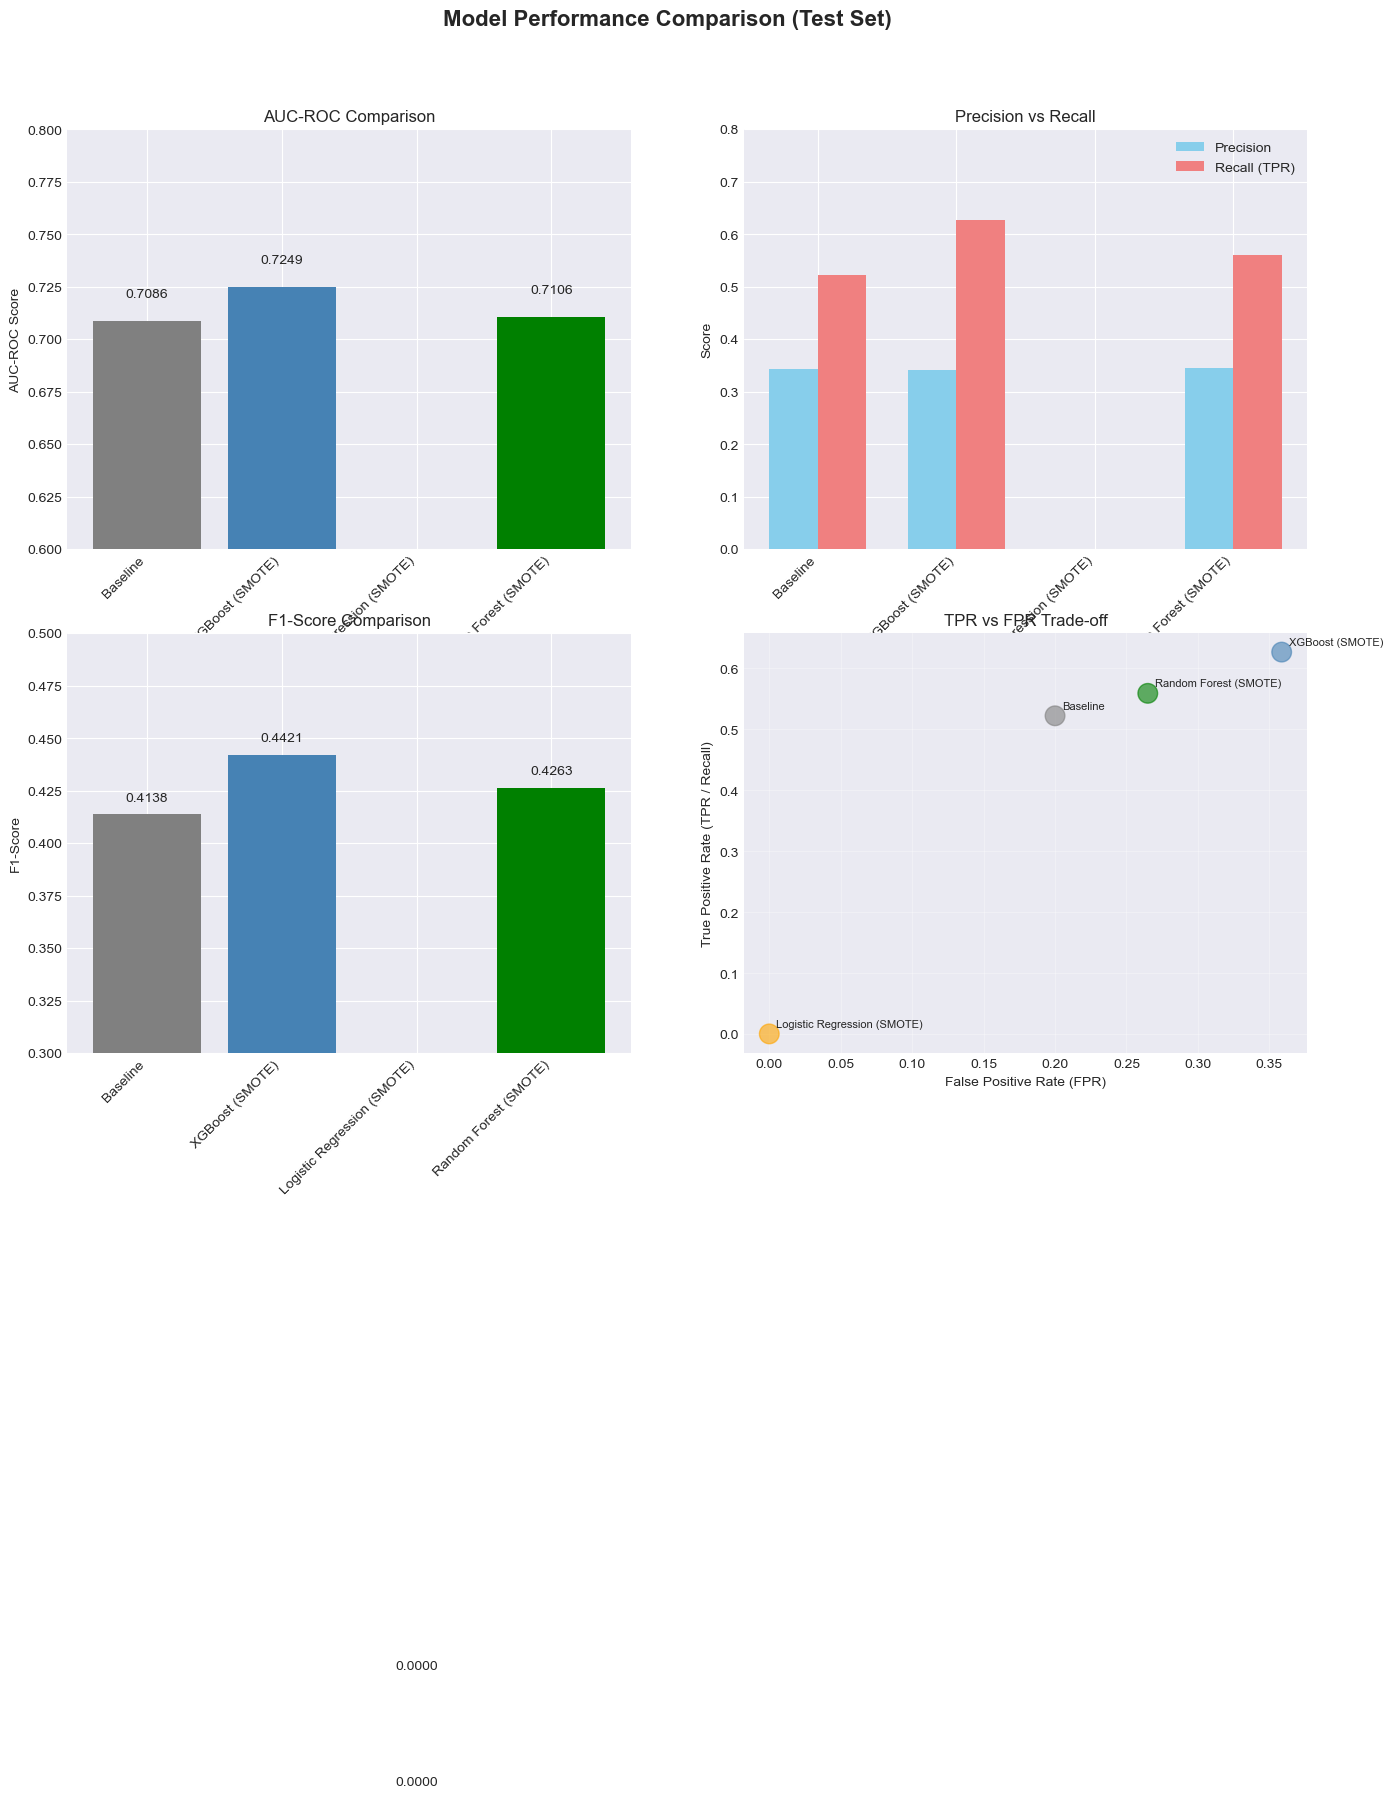

✓ Comparison charts saved to results/figures/


In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Create comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Model Performance Comparison (Test Set)', fontsize=16, fontweight='bold')

models = comparison_df['Model'].tolist()
x_pos = np.arange(len(models))

# Plot 1: AUC-ROC
axes[0, 0].bar(x_pos, comparison_df['AUC-ROC'], color=['gray', 'steelblue', 'orange', 'green'])
axes[0, 0].set_ylabel('AUC-ROC Score')
axes[0, 0].set_title('AUC-ROC Comparison')
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(models, rotation=45, ha='right')
axes[0, 0].set_ylim([0.6, 0.8])
for i, v in enumerate(comparison_df['AUC-ROC']):
    axes[0, 0].text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')

# Plot 2: Precision & Recall
width = 0.35
axes[0, 1].bar(x_pos - width/2, comparison_df['Precision'], width, label='Precision', color='skyblue')
axes[0, 1].bar(x_pos + width/2, comparison_df['Recall (TPR)'], width, label='Recall (TPR)', color='lightcoral')
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_title('Precision vs Recall')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(models, rotation=45, ha='right')
axes[0, 1].legend()
axes[0, 1].set_ylim([0, 0.8])

# Plot 3: F1-Score
axes[1, 0].bar(x_pos, comparison_df['F1-Score'], color=['gray', 'steelblue', 'orange', 'green'])
axes[1, 0].set_ylabel('F1-Score')
axes[1, 0].set_title('F1-Score Comparison')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(models, rotation=45, ha='right')
axes[1, 0].set_ylim([0.3, 0.5])
for i, v in enumerate(comparison_df['F1-Score']):
    axes[1, 0].text(i, v + 0.005, f'{v:.4f}', ha='center', va='bottom')

# Plot 4: TPR vs FPR
axes[1, 1].scatter(comparison_df['FPR'], comparison_df['Recall (TPR)'], 
                   s=200, c=['gray', 'steelblue', 'orange', 'green'], alpha=0.6)
for i, model in enumerate(models):
    axes[1, 1].annotate(model, 
                       (comparison_df['FPR'].iloc[i], comparison_df['Recall (TPR)'].iloc[i]),
                       xytext=(5, 5), textcoords='offset points', fontsize=8)
axes[1, 1].set_xlabel('False Positive Rate (FPR)')
axes[1, 1].set_ylabel('True Positive Rate (TPR / Recall)')
axes[1, 1].set_title('TPR vs FPR Trade-off')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'model_comparison_charts.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Comparison charts saved to results/figures/")

In [16]:
import pickle

# Save metrics to pickle file for easy loading
metrics_to_save = {
    'test_metrics': test_metrics,
    'optimal_threshold': optimal_threshold
}

metrics_path = RESULTS_DIR / 'random_forest_metrics.pkl'
with open(metrics_path, 'wb') as f:
    pickle.dump(metrics_to_save, f)

print(f"✓ Metrics saved to: {metrics_path}")

# Also save predictions CSV
predictions_df = pd.DataFrame({
    'y_true': y_test,
    'y_proba': y_test_proba,
    'y_pred': (y_test_proba >= optimal_threshold).astype(int)
})

predictions_path = RESULTS_DIR / 'random_forest_predictions.csv'
predictions_df.to_csv(predictions_path, index=False)

print(f"✓ Predictions saved to: {predictions_path}")
print("\n" + "="*80)
print("✅ ALL RESULTS SAVED!")
print("="*80)

✓ Metrics saved to: c:\Users\Faheem\Desktop\Umair FYP\FYP2025\credit_risk_fyp\results\random_forest_metrics.pkl
✓ Predictions saved to: c:\Users\Faheem\Desktop\Umair FYP\FYP2025\credit_risk_fyp\results\random_forest_predictions.csv

✅ ALL RESULTS SAVED!


## 14. Save Results for Model Comparison